In [1]:
%load_ext autoreload
%cd ..
%autoreload 2
%load_ext tensorboard

/Users/gimli/projects/igre


In [3]:
import imageio
import matplotlib.pyplot as plt
import cv2
import numpy as np
from src.registration.transformation import Transformation
import src.workers.radial as radial

In [4]:
# Input image(s)
vis_band_filename = "/Users/gimli/Pictures/2014-firenze-data/26-11-2014-provino-bianco/TIF.8bit_norm.255/Ch13_VIS_13_n_8b.tif"
nir_band_filename = "/Users/gimli/Pictures/2014-firenze-data/26-11-2014-provino-bianco/TIF.8bit_norm.255/Ch20_NIR_1230nm_d048_n_8b.tif"

vis = imageio.imread(vis_band_filename)
nir = imageio.imread(nir_band_filename)

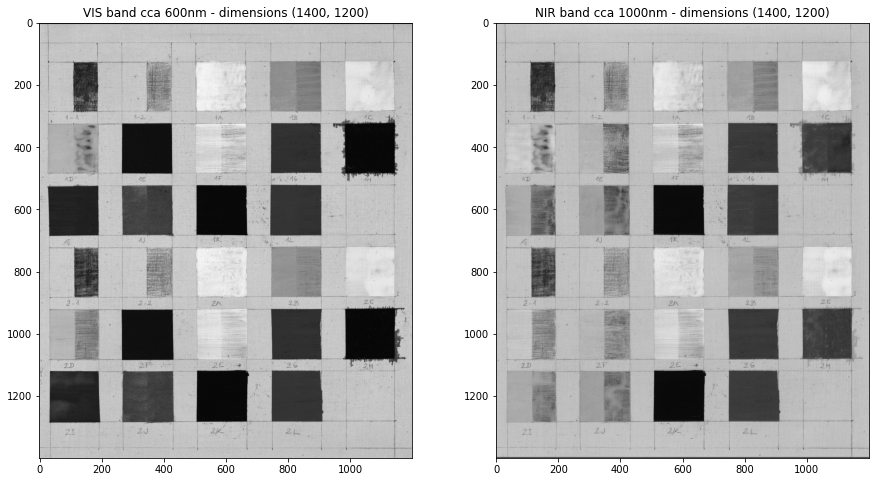

In [5]:
plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1)
ax.imshow(vis, cmap="gray")
ax.set_title(f"VIS band cca 600nm - dimensions {vis.shape}")
ax = plt.subplot(1,2,2)
ax.imshow(nir, cmap="gray")
ax.set_title(f"NIR band cca 1000nm - dimensions {nir.shape}")
plt.show()

In [74]:
# Configuration of input transformation

center = [0, 0]
k1 = 0.05
k2 = 0.03
k3 = 0.01
T3 = Transformation.build_radial(center[0], center[1], k1, k2, k3)
T2 = Transformation.build_radial(center[0], center[1], k1, k2, 0)
T1 = Transformation.build_radial(center[0], center[1], k1, 0, 0)
print(T)

1.00x + 0.00y + 0.00	0.00x + 1.00y + 0.00
--------------------	--------------------
0.00x + 0.00y + 1	0.00x + 0.00y + 1


x + (x - 0) * (0.01r^2 + 0.03r^4 + 0r^6)
y + (y - 0) * (0.01r^2 + 0.03r^4 + 0r^6)


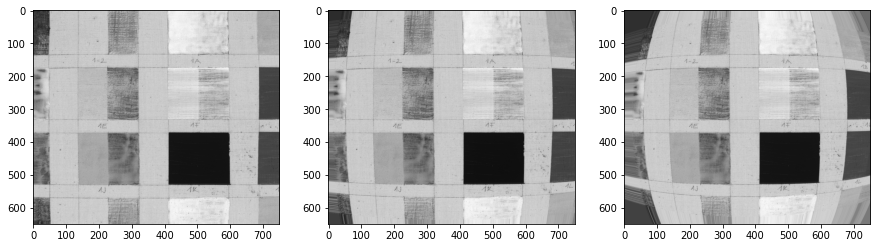

In [73]:
nir_t1 = T1.apply_tform(nir[150:800,150:900])
nir_t2 = T2.apply_tform(nir[150:800,150:900])
nir_t3 = T3.apply_tform(nir[150:800,150:900])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.imshow(nir_t1, cmap="gray")
ax = plt.subplot(1,3,2)
ax.imshow(nir_t2, cmap="gray")
ax = plt.subplot(1,3,3)
ax.imshow(nir_t3, cmap="gray")
plt.show()

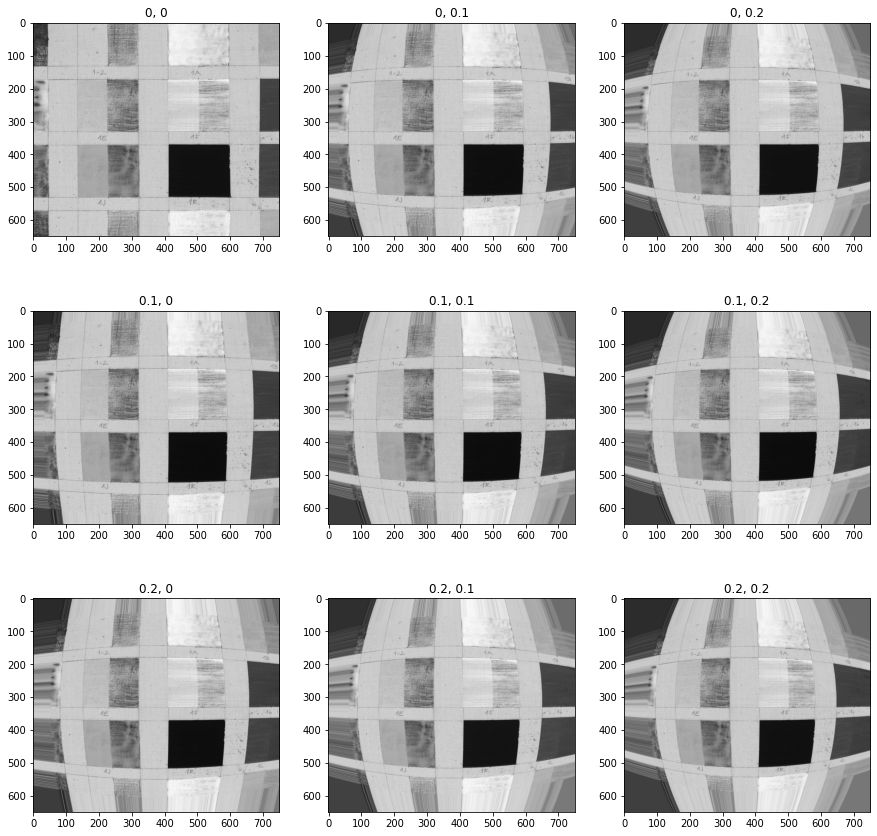

In [80]:
plt.figure(figsize=(15,15))
k = [0, 0.1, 0.2]
for i in range(3):
    for j in range(3):
        T = Transformation.build_radial(0, 0, k[i], k[j], 0)
        ax = plt.subplot(3, 3, i * 3 + j + 1)
        ax.imshow(T.apply_tform(nir[150:800,150:900]), cmap="gray")
        ax.set_title(f"{k[i]}, {k[j]}")
plt.show()

In [142]:
import src.config.image_info as ii
import src.config.tools as cfgtools
import yaml

In [149]:
ii.init(vis.shape[0], vis.shape[1])
cfgtools.get_config()["crop"] = {
    "left_top": {
        "x": 150,
        "y": 150,
    },
    "size": {
        "height": 650,
        "width": 750
    }
}

In [199]:
from src.data.ann.input_preprocessor import training_batch_selection
from src.data.ann.input_preprocessor import pixels_for_training_radial

[autoreload of src.workers.radial failed: Traceback (most recent call last):
  File "/Users/gimli/.pyenv/versions/3.7.6/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/gimli/.pyenv/versions/3.7.6/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/gimli/.pyenv/versions/3.7.6/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/gimli/.pyenv/versions/3.7.6/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/gimli/projects/igre/src/workers/radial.py", line 4, in <module>
    from src.data.ann.input_preprocessor impo

In [164]:
training_batch_selection(1000, nir_t.reshape(650,750,1))

array([ 52051, 441046,  60052, ..., 427604, 157063, 267151])

In [201]:
pixels_for_training_radial(1000, (650,750))

array([[448,  28],
       [136,  70],
       [ 15, 485],
       ...,
       [490,  52],
       [261,   8],
       [563, 122]])

In [202]:
radial.find_tform(vis[150:800,150:900], nir_t)

Config integrity: OK
Building optimizer: {'family': 'adam', 'learning_rate': 0.00025, 'beta1': 0.9, 'beta2': 0.999}
Selecting 25000 samples randomly for use by algorithm.
(50000,)
(50000, 2)
InputLayer
RDistortionLayer
Idx2PixelLayer
Dense0
Dense1
Output
Building optimizer: {'family': 'adam', 'learning_rate': 0.00025, 'beta1': 0.9, 'beta2': 0.999}


InvalidArgumentError: You must feed a value for placeholder tensor 'InputLayer_8' with dtype float and shape [?,2]
	 [[{{node InputLayer_8}}]]

In [ ]:
imageio.imwrite("/Users/gimli/tmp/igre/imgs/nir.png", (nir_t).astype(np.uint8))

In [19]:
coords = np.meshgrid(range(5), range(5))

In [47]:
coord_list = np.stack(coords,axis=2).reshape(25,2)
tcoords, shape = Transformation.normalize_coordinates(coord_list)

In [89]:
from src.data.ann.input_preprocessor import training_batch_selection_radial as sel